In [1]:
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define the catalogs and read them
indir = "./"
gamfile = "gll_psc_v31.fit"   # 4FGL-DR3
ctptfile = "WIBRaLS.fits"
# ctptfile = "CRATES.fits"
# ctptfile = "RASS-bsc.fits"
sra = "RA"
sdec = "DEC"
sid = "NAME"
gamcat = Table.read(indir+gamfile, hdu=1)
# Eliminate sources with invalid localization, like extended sources
valid = np.nonzero(np.logical_not(gamcat['Conf_95_SemiMajor'].mask))[0]
print("gamma catalog:", len(valid), "entries with valid localization among", len(gamcat))
gamcat = gamcat[valid]
ctptcat = Table.read(indir+ctptfile, hdu=1)
print("counterpart catalog:", len(ctptcat), " entries")
print(ctptcat[sra].unit)

gamma catalog: 6579 entries with valid localization among 6659
counterpart catalog: 7855  entries
deg


In [27]:
# ctptcat

In [3]:
# Get Galactic coordinates
ctptdir = SkyCoord(ra=ctptcat[sra], dec=ctptcat[sdec])
galdir = ctptdir.galactic

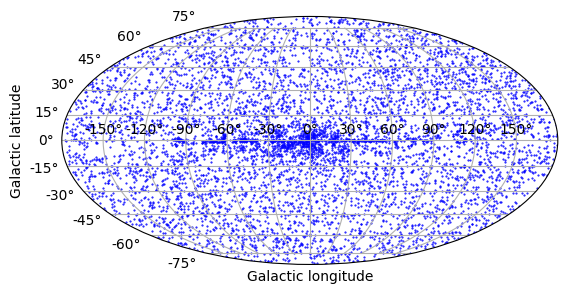

In [4]:
# Show gamma-ray source positions in the sky
# Note that the longitude axis is not inverted
glon = np.mod(gamcat['GLON']+180,360) - 180
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide' ) # or hammer, aitoff, ...
ax.scatter(np.radians(glon), np.radians(gamcat['GLAT']), marker='.', s=1, color='b')
ax.grid(True)
plt.xlabel('Galactic longitude')
plt.ylabel('Galactic latitude')
plt.show()

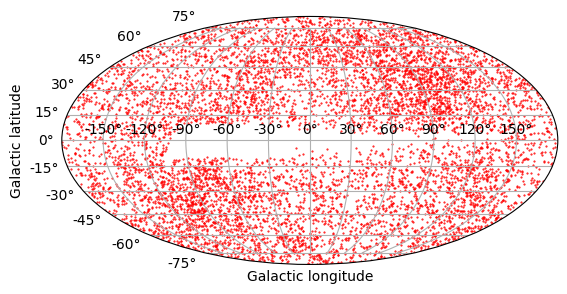

In [5]:
# Show counterpart source positions in the sky
glon2 = np.mod(galdir.l.degree+180,360) - 180
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide' ) # or hammer, aitoff, ...
ax.scatter(np.radians(glon2), galdir.b.radian, marker='.', s=1, color='r')
ax.grid(True)
plt.xlabel('Galactic longitude')
plt.ylabel('Galactic latitude')
plt.show()

In [31]:
# Get average counterpart density, ignoring regions near the Galactic plane
ctpthighlat = np.nonzero(np.abs(galdir.b.degree) > 10)[0]
print("Counterparts at |b| > 10°:", len(ctpthighlat))
rho = len(ctpthighlat) / (4*np.pi*(1-np.cos(np.radians(80)))) * (np.pi/180)**2
print("Counterpart density =", rho, " per square degree")

Counterparts at |b| > 10°: 7297
Counterpart density = 0.2140544339255044  per square degree


In [32]:
# Select high-latitude point-like gamma sources
highlat = np.nonzero(np.abs(gamcat['GLAT']) > 10)[0]
print("Gamma sources at |b| > 10°:", len(highlat))
gamcath = gamcat[highlat]

Gamma sources at |b| > 10°: 4701


In [33]:
# Get closest neighbor
gamdir = SkyCoord(l=gamcath['GLON'], b=gamcath['GLAT'], frame='galactic')
idx, d2d, d3d = gamdir.match_to_catalog_sky(galdir)
print("First match:",gamcath[0]['Source_Name'],ctptcat[idx[0]][sid])

First match: 4FGL J0000.3-7355  WB J0002-7508  


In [34]:
f95 = np.sqrt(-2*np.log(0.05))
print("f95 =", f95)
# Replace error ellipses by circles for simplicity
gamlocerr = np.sqrt(gamcath['Conf_95_SemiMajor']*gamcath['Conf_95_SemiMinor']) / f95
# Check the median localization error
medgamlocerr = np.median(gamlocerr)
print("Median gamma localization error:", medgamlocerr*60, " arcmin")

f95 = 2.4477468306808166
Median gamma localization error: 1.4835048839449883  arcmin


/Users/luanareis/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


0.002231488486406943 684.6352102825115


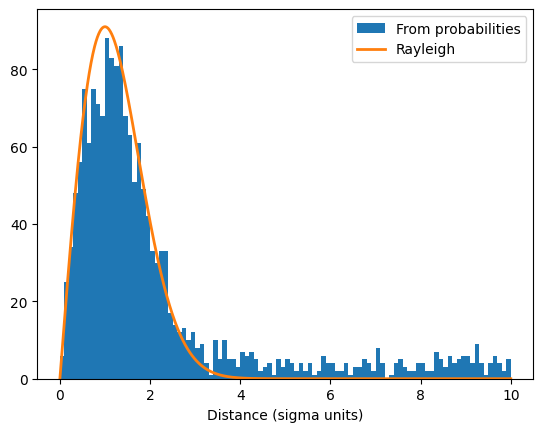

In [35]:
# Show histogram of distance values in sigma units
reldist = d2d.degree / gamlocerr.data
print(np.min(reldist), np.max(reldist))
fig = plt.figure()
ax = fig.add_subplot(111)
rdmax = 10
nbins = 100
rdbin = rdmax / nbins
counts, bins, patches = ax.hist(reldist, range=(0,rdmax), bins=nbins, label='From probabilities')

# Overlay Rayleigh distribution
nok = np.count_nonzero(reldist < 5)
xrd = np.linspace(0, rdmax, 1000)
yrd = rdbin * xrd * np.exp(-xrd**2 / 2)

h = ax.plot(xrd, nok*yrd, lw=2, label='Rayleigh')
h = plt.xlabel('Distance (sigma units)')
h = ax.legend()

In [39]:
# Now define and compute the quantities necessary for the associations
beta = 0.8

# Eliminate sources with too many counterparts in the error radius or LR = 0 (counterpart very far)

# Compute the likelihood ratio LR
LR = (1 / (2 * np.pi * rho * gamlocerr.data**2)) * np.exp(np.pi * rho * reldist**2 - ( reldist**2 / (2 * gamlocerr.data**2 )))
print(np.min(LR), np.max(LR))

# Try a range of Gamma values (Prob{H1}/Prob{H0})
Gamma = np.power(10,np.linspace(-4,1,500))
alpha = 1 / (Gamma * (1/beta-1))
# probas = 1 / (1 + 1/np.outer(Gamma,LR))

0.0 5442.155390952876


In [ ]:
# Get probabilities of false association posfalse

# Deduce the "true" number of false positives as a function of Gamma falseT


In [13]:
# Get expected number of sources inside Rmax by chance numR

# Get expected number of false positives by chance falseR

# Get number of recognized associations as a function of Gamma nrecs
# nrecs = np.count_nonzero(probas > beta, axis=1)

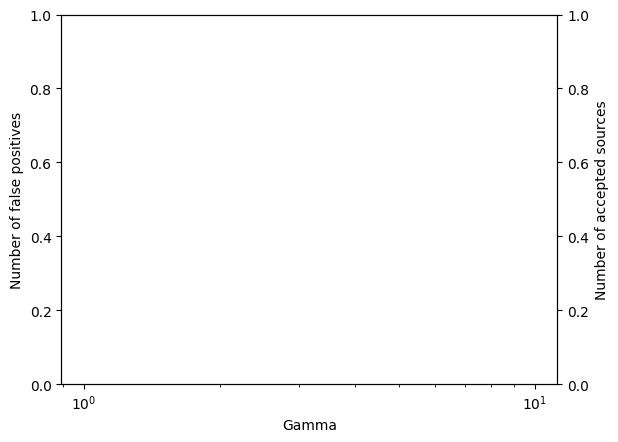

In [14]:
# Plot the curves
fig = plt.figure()
ax = fig.add_subplot(111)
# h = ax.plot(Gamma, falseT, lw=2, label='From probabilities')
# h = ax.plot(Gamma, falseR, lw=2, label='By chance')
# ax.legend(loc='upper left')
ax.set_xscale('log')
ax.set_xlabel('Gamma')
ax.set_ylabel('Number of false positives')
ax2 = ax.twinx()
# h = ax2.plot(Gamma, nrecs, lw=2, color='k')
h = ax2.set_ylabel('Number of accepted sources')

In [15]:
# Deduce the index of the best value of Gamma ibestG

# nfalsepos = falseT[ibestG]
# Gambest = Gamma[ibestG]
# ProbH1 = 1 / (1 + 1/Gambest)
# print("Best Gamma =", Gambest,"corresponding to Pr(H1) =", ProbH1)
# print(nfalsepos, "false positives")

# Get individual probilities of associations at best Gamma probassoc

# Get list of positive associations at best Gamma recassoc

# nrec = len(recassoc)
# print(nrec, "recognized associations corresponding to a fraction of", nrec/len(gamcath))

# Get reliability

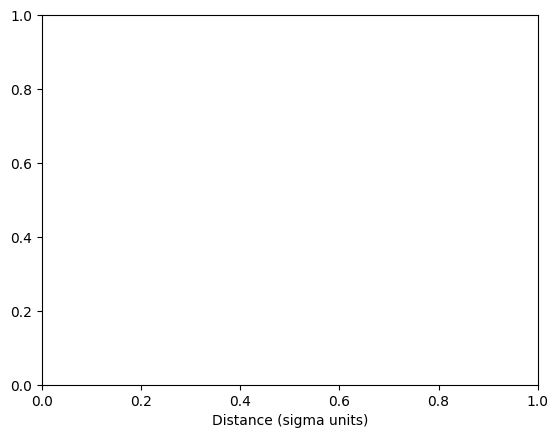

In [16]:
# Redo the Rayleigh plot for those
fig = plt.figure()
ax = fig.add_subplot(111)
# counts, bins, patches = ax.hist(reldist[recassoc], range=(0,rdmax), bins=nbins, label='From probabilities')
# h = ax.plot(xrd, nrec*yrd, lw=2, label='Rayleigh')
# ax.legend()
h = plt.xlabel('Distance (sigma units)')

In [17]:
# Get total estimate of true associations and completeness


Absolute an relative localization systematics: 0.0068 1.06
0.0025048908 0.0073


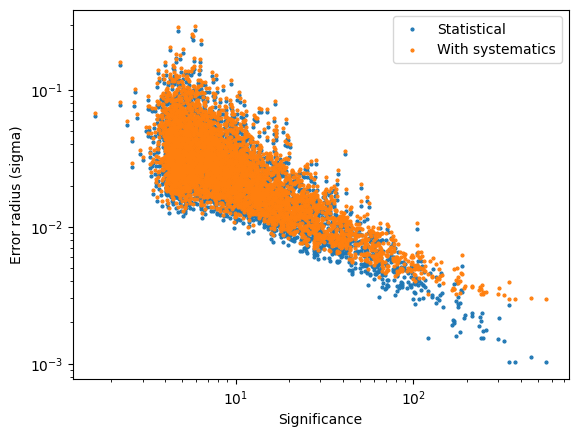

In [18]:
# Go back to original localization
fabs = gamcath.meta['ERPOSABS']
frel = gamcath.meta['ERPOSFAC']
print("Absolute an relative localization systematics:", fabs, frel)
sig1 = np.sqrt(gamcath['Conf_95_SemiMajor']**2 - fabs**2) / frel
sig2 = np.sqrt(gamcath['Conf_95_SemiMinor']**2 - fabs**2) / frel
print(np.min(sig2), np.min(gamcath['Conf_95_SemiMinor']))
sig0 = np.sqrt(sig1*sig2) / f95
# Plot the original 95% localization error
fig = plt.figure()
ax = fig.add_subplot(111)
h = ax.scatter(gamcath['Signif_Avg'], sig0, lw=2, s=1, label='Statistical')
h = ax.scatter(gamcath['Signif_Avg'], gamlocerr, lw=2, s=1, label='With systematics')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
h = ax.set_xlabel('Significance')
h = ax.set_ylabel('Error radius (sigma)')

Text(0, 0.5, 'Angular separation (sigma units)')

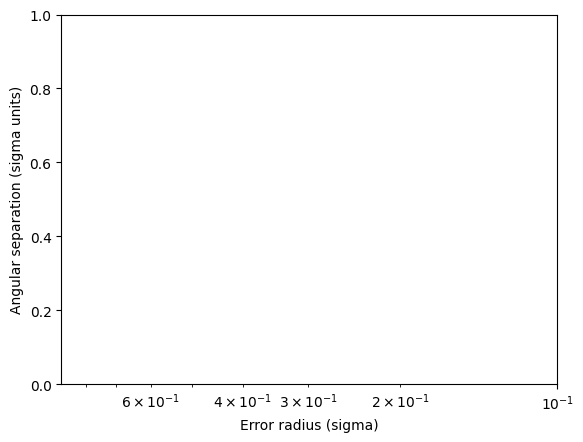

In [19]:
# Recompute the relative distance wrt the original error radius
reldist0 = d2d.degree / sig0.data
# Plot the relative distance to the counterpart as a function of the original error radius
fig = plt.figure()
ax = fig.add_subplot(111)
# h = ax.scatter(sig0[recassoc], reldist0[recassoc], lw=2, s=1, label='Statistical')
# h = ax.scatter(sig0[recassoc], reldist[recassoc], lw=2, s=1, label='With systematics')
# ax.legend()
ax.set_xscale('log')
ax.set_xlim(xmax=0.1)   # Must be done after log scale
ax.set_xlabel('Error radius (sigma)')
ax.set_ylabel('Angular separation (sigma units)')